# Project: Investigate a Dataset - TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I've selected the "**TMDb movie data**" dataset. I chose this because I am a big fan of films from all decades, and I found it interesting for my analysis. Since I am genuinely interested in films, it made it easier to formulate the questions.

#### I will be answering the following questions:

1. What are the most popular genres (by movie count)?
2. Is there a correlation between rating and runtime?
3. What is the average runtime depending on the genre?
4. What is the average budget depending on the genre?
5. Have movies become more expensive over time (After considering inflation)?
6. What are the most commercially succesful movies by revenue? How about for adjusted revenue?
7. What are the most succesful movies by rating?
8. What are the average amount of movies a director has done?
9. How do votes, budgets and revenues behave through a single-variable exploration?

In [207]:
#My imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### Loading the data
I loaded the data directly from the URI as the read_csv method allows it

In [208]:
tmdb_dataframe_uri = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv';
df_tmdb = pd.read_csv(tmdb_dataframe_uri)

Now I will do a quick "head" check to view a sample row of the dataset

In [209]:
df_tmdb.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


Let's check the types of the items to see if any needs to be changed

In [210]:
df_tmdb.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

I didn't identify any value that needs to have its type changed, therefore no need to modify any types.

Moving on, let's see how big this dataset is.

In [211]:
df_tmdb.shape

(10866, 21)

This is a big dataset, let's check for duplicates

In [212]:
df_tmdb.duplicated().sum()

1

In [213]:
#Ok there is one, lets look for it by id
df_tmdb[df_tmdb.duplicated()]['id']

2090    42194
Name: id, dtype: int64

In [214]:
#let's see the actual data
df_tmdb.query('id == 42194')

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2089,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,30000000.0,967000.0
2090,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,30000000.0,967000.0


In [215]:
#Let's drop duplicates, we don't need them
df_tmdb.drop_duplicates(inplace=True)

In [216]:
#Checking acount to see if they are there, response should be "0"
df_tmdb.duplicated().sum()

0

In [217]:
df_tmdb.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7929
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

Here I see that director is empty on 44 movies. I will also be dropping these since I need director information to answer some of the questions

### Wrangling - Dropping films without director

In [218]:
df_tmdb.shape

(10865, 21)

In [219]:
#Create new dataset based on a mask of the rows with not null values on director
df_tmdb = df_tmdb[df_tmdb.director.notnull()]
df_tmdb.isnull().sum()

id                         0
imdb_id                    6
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      70
homepage                7895
director                   0
tagline                 2790
keywords                1465
overview                   3
runtime                    0
genres                    21
production_companies    1007
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [220]:
df_tmdb.shape

(10821, 21)

### Wrangling - Dropping films without genres
I will be using genres in my analysis, therefore I will create a new dataset exclusing the movies that have no genre

In [221]:
#How many rows do we have to drop?
df_tmdb.genres.isnull().sum()

21

In [222]:
df_tmdb = df_tmdb[df_tmdb.genres.notnull()]
#Let's validate that the 21 rows are not included in this dataset
df_tmdb.shape[0]

10800

In [223]:
#Now I double check that there are no null values in genres
df_tmdb.isnull().sum()

id                         0
imdb_id                    5
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      69
homepage                7879
director                   0
tagline                 2774
keywords                1449
overview                   2
runtime                    0
genres                     0
production_companies     994
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

To improve performance and readability, let's limit the dataframe to only have the specific columns we need to answer our questions.

1. id
2. popularity
3. budget_adj
4. revenue_adj
5. original_title
6. director
7. overview
8. runtime
9. genres
10. production_companies
11. release_date
12. vote_count
13. vote_average
14. release_year

In [224]:
columns = ['id','popularity','budget','budget_adj','revenue','revenue_adj','original_title','director',
           'overview','runtime','genres','production_companies','release_date','vote_count',
           'vote_average','release_year']

In [225]:
df_tmdb = df_tmdb[columns]

In [226]:
df_tmdb.dtypes

id                        int64
popularity              float64
budget                    int64
budget_adj              float64
revenue                   int64
revenue_adj             float64
original_title           object
director                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
dtype: object

In [227]:
df_tmdb.head(1)

,id,popularity,budget,budget_adj,revenue,revenue_adj,original_title,director,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year
0,135397,32.985763,150000000,1.379999e+08,1513528810,1.392446e+09,Jurassic World,Colin Trevorrow,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015


<a id='eda'></a>
## Exploratory Data Analysis

First, let me create a function so I can add the labels to dataframe visualizations using pandas easier.

In [228]:
import matplotlib

def set_title_and_axes_labels(ax: matplotlib.axes.Axes, title: str, xlabel: str, ylabel: str):
    ax.set_title(title)
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);

The second function I will use is to create a custom DataFrame between the genres and the other variables I am going to use for my questions

In [229]:
import pandas

def get_genre_relationship_df(main_df: pandas.DataFrame, related_variable: str):
    temp_genres_df = df_tmdb.genres.str.split('|', expand=True)
    df = pd.concat([df_tmdb[related_variable], temp_genres_df], axis=1, join='outer', ignore_index=False)
    
    #Now using the 'melt' function to create rows for each combination of movie:genre
    df = pd.melt(df, id_vars=[related_variable])
    print(f'Melt DataFrame Rows: {df.shape[0]}')
    
    #Let's drop all the nulls
    df = df[[related_variable, 'value']].rename(columns={'value':'genre'})
    df = df.dropna(axis=0, how='any')
    print(f'Cleaned DataFrame Rows: {df.shape[0]}')
    
    return df

## <font color=green>1. What are the most popular genres (by movie count)</font>

I will be creating a temporary dataframe for genre and movies to use for this question

In [230]:
genre_title_df = get_genre_relationship_df(df_tmdb, 'original_title')
genre_title_df.head(5)

Melt DataFrame Rows: 54000
Cleaned DataFrame Rows: 26864


,original_title,genre
0,Jurassic World,Action
1,Mad Max: Fury Road,Action
2,Insurgent,Adventure
3,Star Wars: The Force Awakens,Action
4,Furious 7,Action


In [231]:
#using numpy to get the unique genres
list_of_genres = np.unique(genre_title_df.genre)

In [232]:
for genre in list_of_genres:
    print(genre)

Action
Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
Fantasy
Foreign
History
Horror
Music
Mystery
Romance
Science Fiction
TV Movie
Thriller
War
Western


In [233]:
#Counting the number of films per genre (individually)
genres_count_df = genre_title_df.groupby(by='genre').count()
genres_count_df = genres_count_df.rename(columns={'original_title':'Count'})
genres_count_df

,Count
genre,
Action,2378
Adventure,1466
Animation,692
Comedy,3782
Crime,1353
Documentary,509
Drama,4754
Family,1223
Fantasy,912


#### Plotting with Pandas

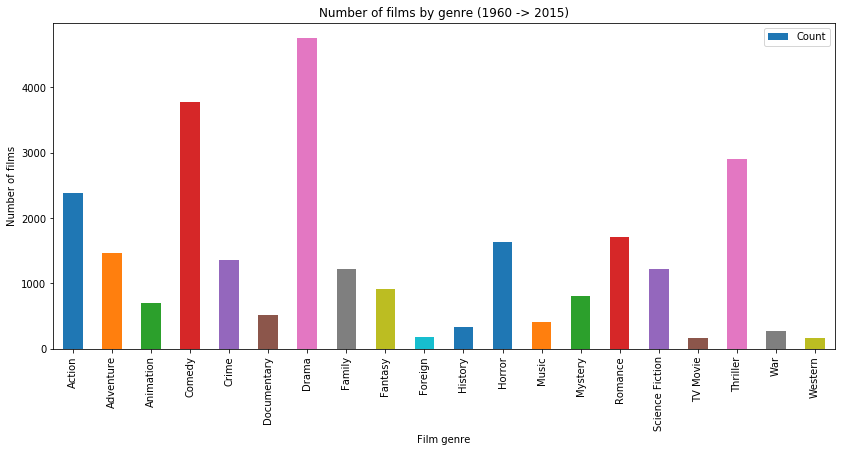

In [234]:
genres_count_df_ax = genres_count_df.plot(y = 'Count', kind='bar', figsize=(14,6));
set_title_and_axes_labels(genres_count_df_ax,'Number of films by genre (1960 -> 2015)', 'Film genre', \
                          'Number of films')
# genres_count_df_ax.set_title('Number of films by genre (1960 -> 2015)')
# genres_count_df_ax.set_ylabel('Number of films');
# genres_count_df_ax.set_xlabel('Film genre');

#### Plotting with matplotlib

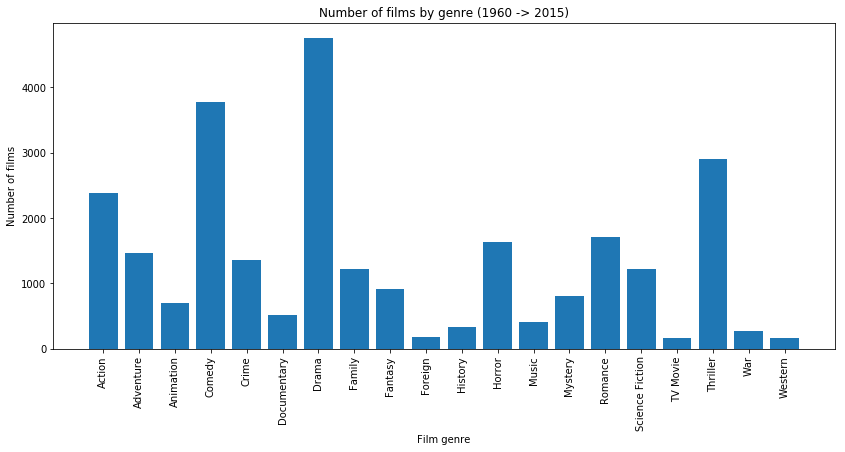

In [235]:
x_axis = genres_count_df.index
y_axis = genres_count_df.Count
plt.figure(figsize=(14,6))
plt.bar(x_axis, y_axis);
plt.title('Number of films by genre (1960 -> 2015)')
plt.xlabel('Film genre');
plt.xticks(rotation='vertical')
plt.ylabel('Number of films');

#### In summary, here are the top 5 most common movie genres in the dataset

In [236]:
most_common_genres_df = genres_count_df.sort_values(by='Count', ascending=False).head(5)
most_common_genres_df

,Count
genre,
Drama,4754
Comedy,3782
Thriller,2904
Action,2378
Romance,1708


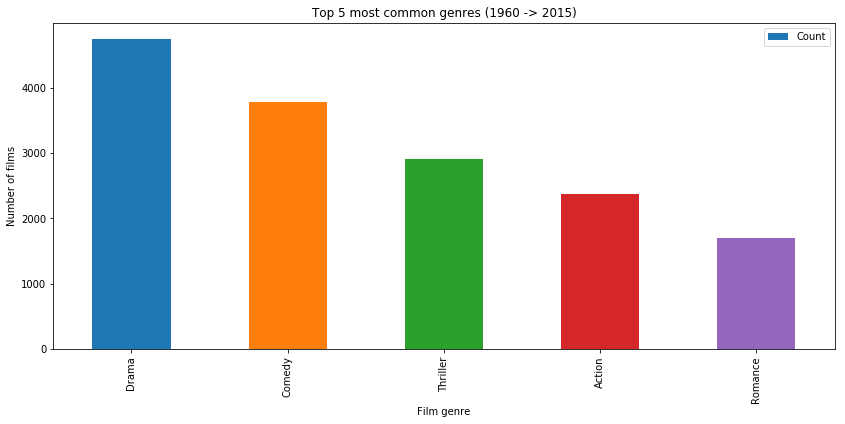

In [237]:
most_common_genres_df_ax = most_common_genres_df.plot(y = 'Count', kind='bar', figsize=(14,6));
set_title_and_axes_labels(most_common_genres_df_ax,'Top 5 most common genres (1960 -> 2015)', 'Film genre', \
                          'Number of films')

### <font color=red>Answer to question #1</font>
The top 5 genres (not by vote but by the amount of movies made of said genre) are:
1. Drama
2. Comedy
3. Thriller
4. Action
5. Romance

I asked a few people what their top 3 genres are, and the majority included at least 2 of this list.

## <font color=green> 2. Is there a correlation between rating and runtime? </font>

Let's see if people tend to give lower ratings to shorter movies, and if longer movies have any impact on perceived quality of the film, resulting in higher ratings

In [238]:
runtime_rating_df = df_tmdb[['runtime', 'vote_average']]

print(runtime_rating_df.dtypes)

runtime           int64
vote_average    float64
dtype: object


In [239]:
runtime_rating_df.corr()

,runtime,vote_average
runtime,1.000000,0.165142
vote_average,0.165142,1.000000


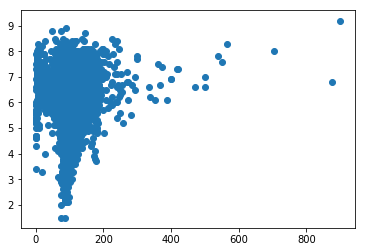

In [240]:
plt.scatter(runtime_rating_df.runtime, runtime_rating_df.vote_average);

In [241]:
runtime_rating_df.runtime.max()

900

I see some values that are outliers (after 200 mins, movies are over 3h20m long, those are not very common, and the max runtime seems to be 900!). Let's take these outliers out and try again

In [242]:
runtime_rating_df = runtime_rating_df.query('runtime <= 200')

runtime_rating_df.runtime.max()

200

In [243]:
runtime_rating_df.corr()

,runtime,vote_average
runtime,1.000000,0.150747
vote_average,0.150747,1.000000


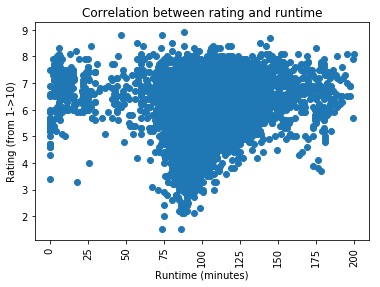

In [244]:
plt.title('Correlation between rating and runtime')
plt.xlabel('Runtime (minutes)');
plt.xticks(rotation='vertical')
plt.ylabel('Rating (from 1->10)');
plt.scatter(runtime_rating_df.runtime, runtime_rating_df.vote_average);

### <font color=red>Answer to question #2</font>

There doesn't seem to be any correlation between movie rating and runtime (the df.corr() function showed it, but graphically it is easier to see)

## <font color=green>3. What is the average runtime depending on the genre?</font>

For this, I will have to use again the separated genres. Luckily I already have a list of separated genres declared above.

In [245]:
#First I create a dataframe with the columns as the list of genres
genre_runtime_df = pd.DataFrame(columns = list_of_genres)
genre_runtime_df.dtypes

Action             object
Adventure          object
Animation          object
Comedy             object
Crime              object
Documentary        object
Drama              object
Family             object
Fantasy            object
Foreign            object
History            object
Horror             object
Music              object
Mystery            object
Romance            object
Science Fiction    object
TV Movie           object
Thriller           object
War                object
Western            object
dtype: object

I see that all values are strings, however I need them to be in integers

In [246]:
genre_runtime_df = genre_runtime_df.astype('int16')
genre_runtime_df.dtypes

Action             int16
Adventure          int16
Animation          int16
Comedy             int16
Crime              int16
Documentary        int16
Drama              int16
Family             int16
Fantasy            int16
Foreign            int16
History            int16
Horror             int16
Music              int16
Mystery            int16
Romance            int16
Science Fiction    int16
TV Movie           int16
Thriller           int16
War                int16
Western            int16
dtype: object

Excellent, now let's fill this temporary dataframe with the runtime values from the original depending on genre

In [247]:
# %%timeit
# #This was taking fovever, so I decided to timeit

# for index, movie in df_tmdb.iterrows():
#     temp_row = pd.Series()
#     for genre in list_of_genres:
#         if genre in movie.genres:
#             temp_row[genre] = movie.runtime

_30.3 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)_

I reviewed the code and decided to add "break" after finding the genre and creating/updating the temp row since the remaining iterations wouldn't do anything as the genre had already been found.

After this, I timed it again:

In [248]:
# %%timeit

# for index, movie in df_tmdb.iterrows():
#     temp_row = pd.Series()
#     for genre in list_of_genres:
#         if genre in movie.genres:
#             temp_row[genre] = movie.runtime
#             break

_13.4 s ± 74.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)_

(Discard) The first method took 30 seconds, this one took 13, over a 50% time reduction.

In [249]:
##Commented, now using concat + melt to achieve same results much faster

# for index, movie in df_tmdb.iterrows():
#     temp_row = pd.Series()
#     for genre in list_of_genres:
#         if genre in movie.genres:
#             temp_row[genre] = movie.runtime
#             genre_runtime_df = genre_runtime_df.append(temp_row, ignore_index=True)

In [250]:
genre_runtime_df.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western


In [251]:
genre_runtime_df = get_genre_relationship_df(df_tmdb, 'runtime')
genre_runtime_df.head(5)

Melt DataFrame Rows: 54000
Cleaned DataFrame Rows: 26864


,runtime,genre
0,124,Action
1,120,Action
2,119,Adventure
3,136,Action
4,137,Action


Now let's calculate the mean duration of each genre

In [252]:
genre_runtime_df = genre_runtime_df.groupby(by='genre').mean()
genre_runtime_df

,runtime
genre,
Action,105.045416
Adventure,106.367667
Animation,68.349711
Comedy,96.803014
Crime,106.926829
Documentary,103.125737
Drama,110.398612
Family,89.688471
Fantasy,100.891447


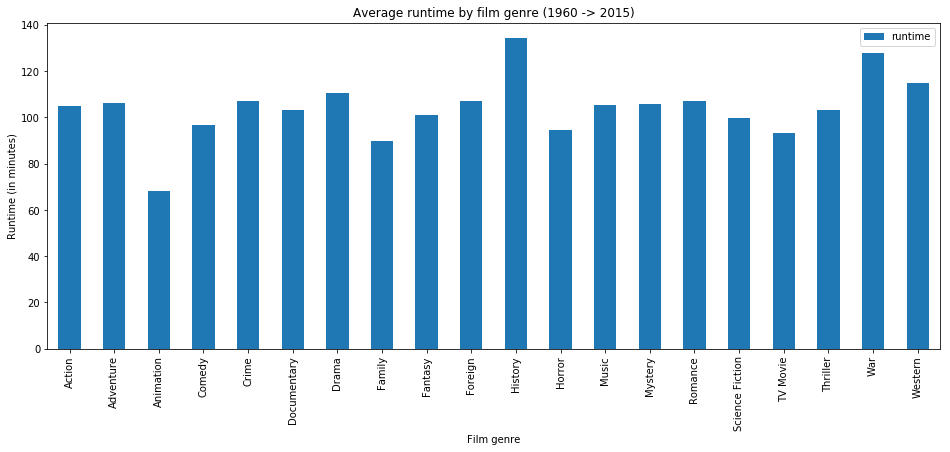

In [253]:
ax = genre_runtime_df.plot(kind='bar', figsize=(16,6));
set_title_and_axes_labels(ax,'Average runtime by film genre (1960 -> 2015)', \
                         'Film genre', 'Runtime (in minutes)')

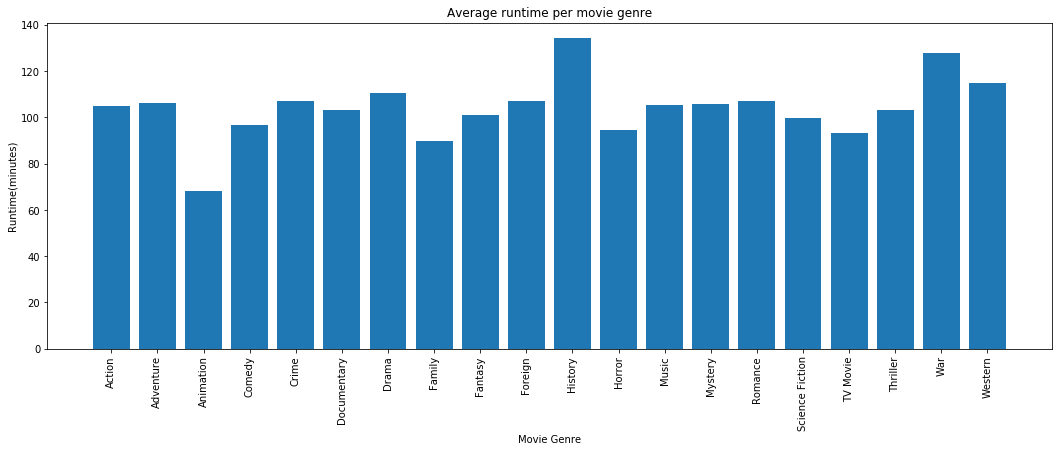

In [254]:
x_axis = genre_runtime_df.index
y_axis = genre_runtime_df.runtime
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Average runtime per movie genre')
plt.xlabel('Movie Genre');
plt.xticks(rotation='vertical')
plt.ylabel('Runtime(minutes)');

Besides the min and max values, all other films look to be similar in the chart. 

### Let's sort them to better see the data

In [255]:
genre_runtime_df.sort_values('runtime', inplace=True)
genre_runtime_df

,runtime
genre,
Animation,68.349711
Family,89.688471
TV Movie,93.271605
Horror,94.426039
Comedy,96.803014
Science Fiction,99.658217
Fantasy,100.891447
Documentary,103.125737
Thriller,103.282713


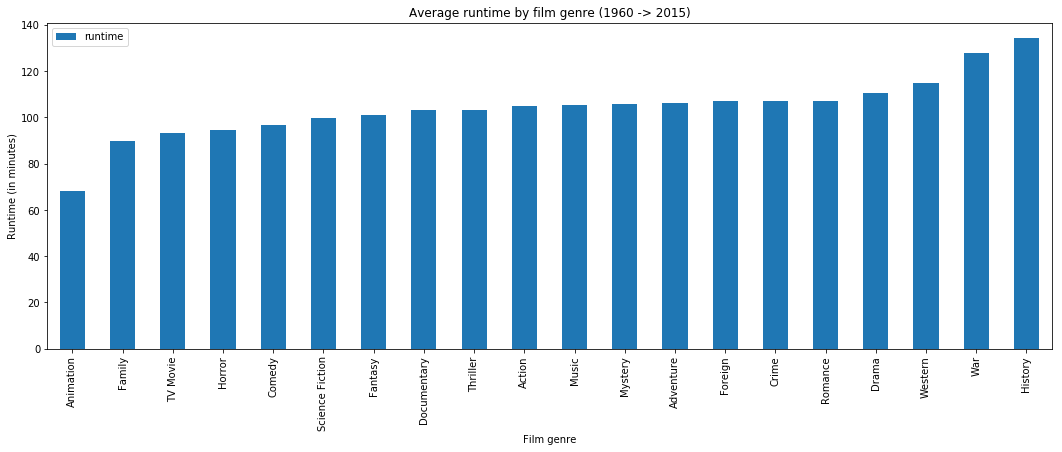

In [256]:
question_3_subplot = genre_runtime_df.plot(kind='bar', figsize=(18,6));
question_3_subplot.set_title('Average runtime by film genre (1960 -> 2015)')
question_3_subplot.set_ylabel('Runtime (in minutes)');
question_3_subplot.set_xlabel('Film genre');

### <font color=red>Answer to question #3</font>

There doesn't seem to be a noticeable difference in movie runtines, with the exception of two:
- History and War films are, on average, noticeably longer than other films
- Animation films are, on average, noticeably shorter than other films

## <font color=green>4. What is the average budget depending on the genre?</font>

Since the dataframe has multiple genres per film, we again have to create a specific dataframe for this operation

In [257]:
genre_budget_df = get_genre_relationship_df(df_tmdb, 'budget')
genre_budget_df.head(5)

Melt DataFrame Rows: 54000
Cleaned DataFrame Rows: 26864


,budget,genre
0,150000000,Action
1,150000000,Action
2,110000000,Adventure
3,200000000,Action
4,190000000,Action


In [258]:
genre_budget_df.min()

budget         0
genre     Action
dtype: object

I can already see that there are movies with 0 as budget, those won't work. Let's remove them

In [259]:
genre_budget_df = genre_budget_df.query('budget != 0')
genre_budget_df.min()

budget         1
genre     Action
dtype: object

In [260]:
genre_budget_df.dtypes

budget     int64
genre     object
dtype: object

In [261]:
#Divide by 1MM to represent values in MM
genre_budget_df.budget = genre_budget_df.budget.apply(lambda x : x/1000000)
genre_budget_df

,budget,genre
0,150.000000,Action
1,150.000000,Action
2,110.000000,Adventure
3,200.000000,Action
4,190.000000,Action
5,135.000000,Western
6,155.000000,Science Fiction
7,108.000000,Drama
8,74.000000,Family
9,175.000000,Comedy


In [262]:
#group by genre and get average budget
genre_budget_df = genre_budget_df.groupby('genre').mean()

#sort them for easier viewing
genre_budget_df.sort_values(by='budget',inplace=True)

#Divide by 1,000,000 to display the values as MM in the chart, easier to see
# genre_budget_df = genre_budget_df.budget.apply(lambda x: x/1000000)

#view data
genre_budget_df

,budget
genre,
Documentary,4.761390
TV Movie,4.966667
Foreign,8.043629
Horror,13.323959
Music,22.786746
Drama,24.435949
Romance,24.941113
Comedy,29.016003
Crime,29.060494


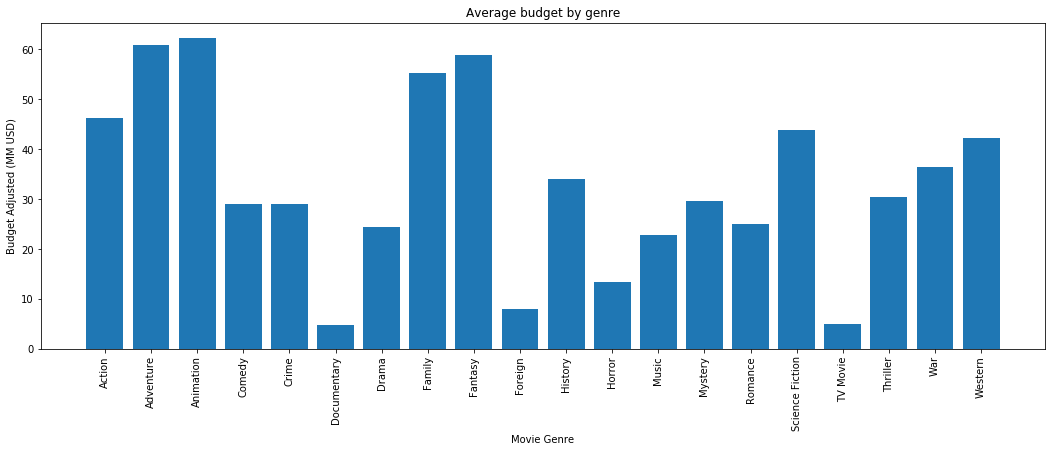

In [263]:
x_axis = genre_budget_df.index
y_axis = genre_budget_df.budget
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Average budget by genre')
plt.xlabel('Movie Genre');
plt.xticks(rotation='vertical')
plt.ylabel('Budget Adjusted (MM USD)');

Let's look at them sorted

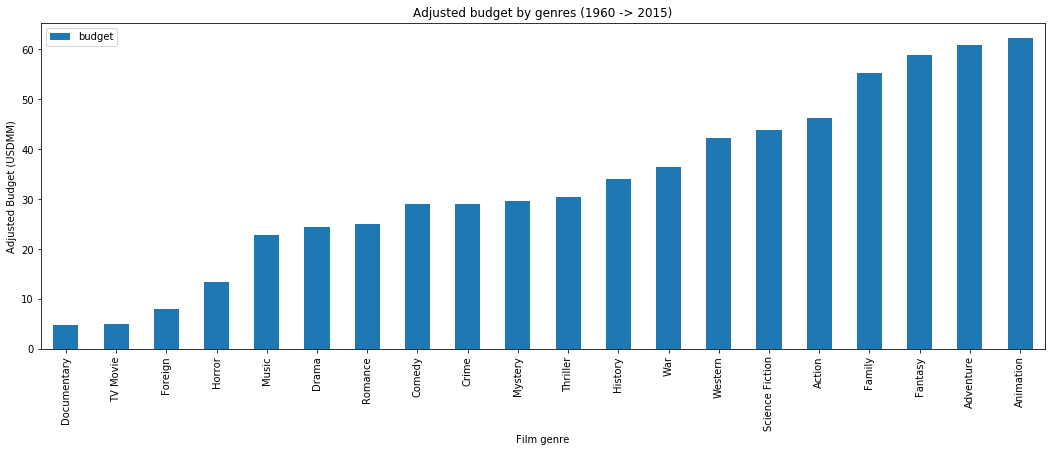

In [264]:
question_4_subplot = genre_budget_df.plot(kind='bar', figsize=(18,6));
set_title_and_axes_labels(question_4_subplot,'Adjusted budget by genres (1960 -> 2015)', \
                         'Film genre', 'Adjusted Budget (USDMM)')

### <font color=red>Answer to question #4</font>

Animation, Fantasy and Adventure are the Top3 most expensive films to produce, while Documentaries, TV Movies and Foreign Films are the most affordable (Or have the lowest budget)

## <font color=green>5. Have movies become more expensive over time (after considering inflation)?</font>

In [265]:
budget_year_df = df_tmdb.groupby(by='release_year').budget_adj.mean()
budget_year_df = budget_year_df.to_frame()
#Divide by 1,000,000 to represent values in MM
budget_year_df = budget_year_df.apply(lambda x : x / 1000000)

In [266]:
budget_year_df.tail(30)

,budget_adj
release_year,
1986,11.583502
1987,10.892022
1988,11.848895
1989,13.963965
1990,16.308705
1991,17.650941
1992,16.846153
1993,15.176814
1994,17.822893


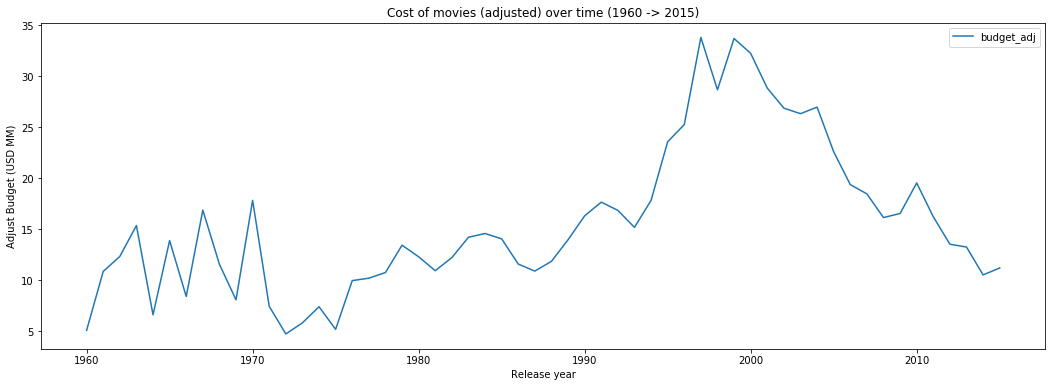

In [267]:
ax = budget_year_df.plot(kind='line', figsize=(18,6));
set_title_and_axes_labels(ax, 'Cost of movies (adjusted) over time (1960 -> 2015)', 'Release year', 'Adjust Budget (USD MM)')
# question_5_subplot.set_ylabel('Adjusted Budget (USDMM)');
# question_5_subplot.set_xlabel('Release year');

### <font color=red>Answer to question #5</font>

There seems to have been a spike in the late 90s and early 2000s, however, the budget of films decreased radically, perhaps due to advancements in editing or renting equipment, or simply because there weren't sufficient returns on those budgets.

Could also be the peak of Adventure and Animation films since, as we saw in the previous questions, are the most expensive films to produce.

The answer is **yes**, movies have  become more expensive to produce over time, after adjusting for inflation. However, if we were to draw a CAGR from the 1960 to 2015, it would show a very minimal increase. We must consider the drastic spike of late 90s/early 2000s to appreciate the increase in cost over time

## <font color=green>6. What are the most succesful movies by revenue? How about for adjusted revenue?</font>

### By revenue

In [268]:
most_successful_movies_by_revenue_df = df_tmdb.sort_values(by='revenue', ascending=False).head(5)
#Divide the revenue by 9 zeros to show in BN
most_successful_movies_by_revenue_df['revenue'] = most_successful_movies_by_revenue_df['revenue'].apply(lambda x : x/1000000000)
most_successful_movies_by_revenue_df[['original_title','revenue']]

,original_title,revenue
1386,Avatar,2.781506
3,Star Wars: The Force Awakens,2.068178
5231,Titanic,1.845034
4361,The Avengers,1.519558
0,Jurassic World,1.513529


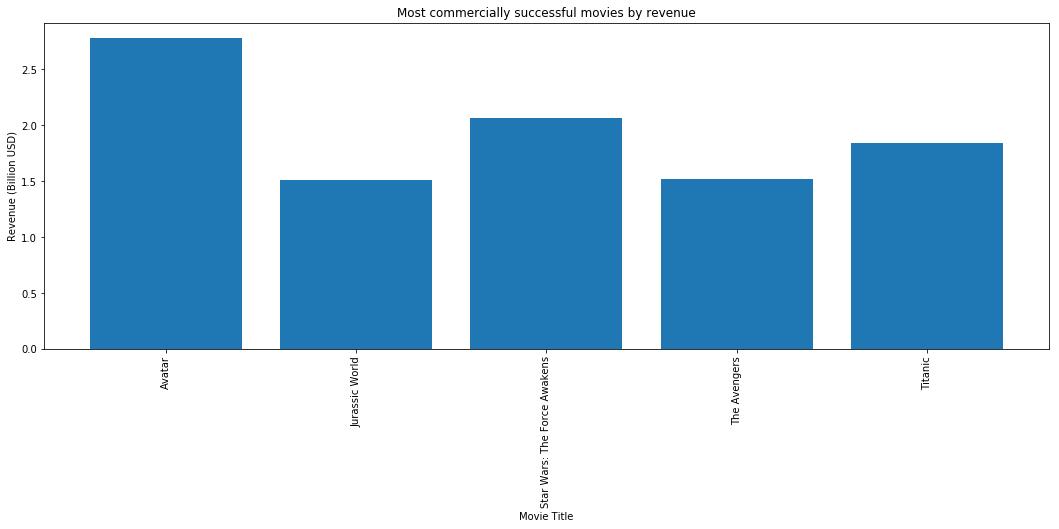

In [269]:
x_axis = most_successful_movies_by_revenue_df.original_title
y_axis = most_successful_movies_by_revenue_df.revenue
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Most commercially successful movies by revenue')
plt.xlabel('Movie Title');
plt.xticks(rotation='vertical')
plt.ylabel('Revenue (Billion USD)');

### By adjusted revenue

In [270]:
most_successful_movies_by_adjusted_revenue_df = df_tmdb.sort_values(by='revenue_adj', ascending=False).head(5)
#Divide the revenue by 9 zeros to show in BN
most_successful_movies_by_adjusted_revenue_df['revenue_adj'] = most_successful_movies_by_adjusted_revenue_df['revenue_adj'].apply(lambda x : x/1000000000)
most_successful_movies_by_adjusted_revenue_df[['original_title','revenue_adj']]

,original_title,revenue_adj
1386,Avatar,2.827124
1329,Star Wars,2.789712
5231,Titanic,2.506406
10594,The Exorcist,2.167325
9806,Jaws,1.907006


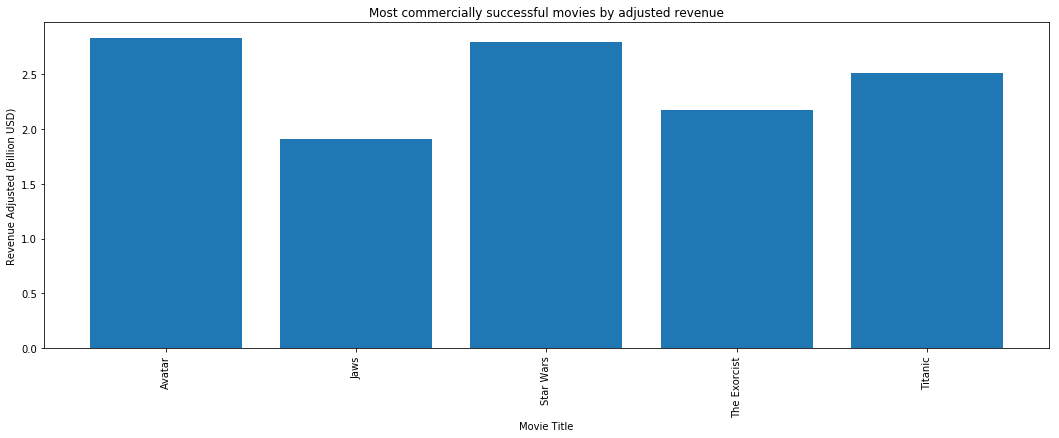

In [271]:
x_axis = most_successful_movies_by_adjusted_revenue_df.original_title
y_axis = most_successful_movies_by_adjusted_revenue_df.revenue_adj
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Most commercially successful movies by adjusted revenue')
plt.xlabel('Movie Title');
plt.xticks(rotation='vertical')
plt.ylabel('Revenue Adjusted (Billion USD)');

### <font color=red>Answer to question #6</font>

The most commercially successful movies by adjusted revenueare:
1. Avatar
2. Star Wars
3. Titanic
4. The Exorcist
5. Jaws

## <font color=green>7. What are the most succesful movies by rating?</font>

In [272]:
most_successful_movies_by_rating_df = df_tmdb.sort_values(by='vote_average', ascending=False).head(5)
most_successful_movies_by_rating_df[['vote_count','vote_average','original_title']].head()

,vote_count,vote_average,original_title
3894,14,9.2,The Story of Film: An Odyssey
538,11,8.9,The Mask You Live In
1200,41,8.8,Black Mirror: White Christmas
2269,27,8.8,Life Cycles
6911,23,8.7,Pink Floyd: Pulse


While I agree that Black Mirror is the greatest show ever, these films have very limited vote counts, so let's see what the average vote count is 

In [273]:
df_tmdb.vote_count.describe()

count    10800.000000
mean       218.600741
std        577.165055
min         10.000000
25%         17.000000
50%         39.000000
75%        147.000000
max       9767.000000
Name: vote_count, dtype: float64

The average is 218 votes per film, but there's a max of over 9,000! I am curious how many films have 4 digits of vote counts

In [274]:
df_tmdb.query('vote_count > 999').shape[0]

564

I am content with the amount of films (564) that have gathered over 1,000 votes, I will be choosing the most succesful from that datarame.

In [275]:
most_successful_movies_by_rating_df = df_tmdb.query('vote_count > 999')
most_successful_movies_by_rating_df = most_successful_movies_by_rating_df.sort_values(by='vote_average', ascending=False).head(5)

In [276]:
most_successful_movies_by_rating_df[['original_title','vote_average']]

,original_title,vote_average
4178,The Shawshank Redemption,8.4
7269,The Godfather,8.3
650,Whiplash,8.2
4177,Pulp Fiction,8.1
4179,Forrest Gump,8.1


Now THAT is a list that we can all agree on

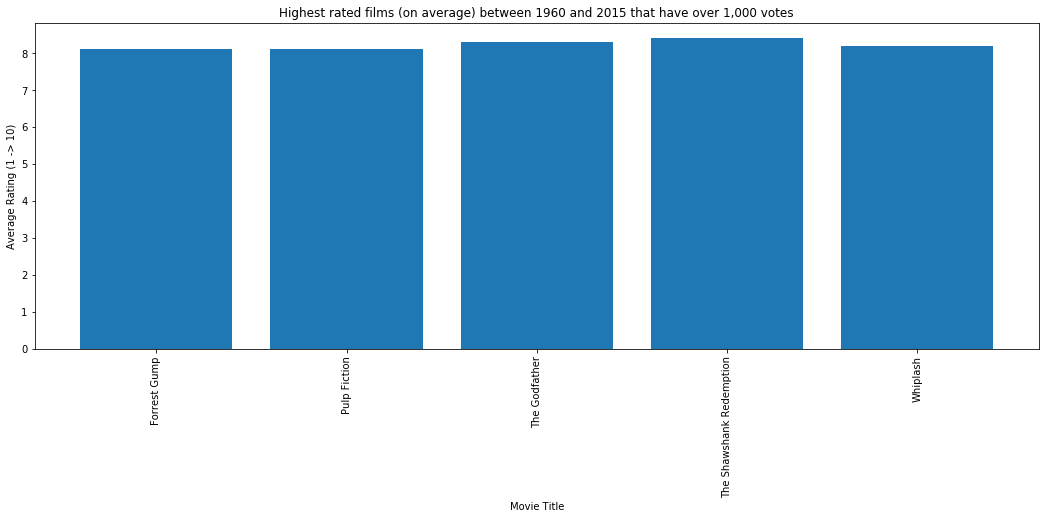

In [277]:
x_axis = most_successful_movies_by_rating_df.original_title
y_axis = most_successful_movies_by_rating_df.vote_average
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Highest rated films (on average) between 1960 and 2015 that have over 1,000 votes')
plt.xlabel('Movie Title');
plt.xticks(rotation='vertical')
plt.ylabel('Average Rating (1 -> 10)');

### <font color=red>Answer to question #7</font>

The highest rated films (on average) between 1960 and 2015 that have over 1,000 votes are:
1. The Shawshank Redemption
2. The Godfather
3. Whiplash (What a surprise)
4. Pulp Fiction
5. Forrest Gump

## <font color=green>8. What are the average amount of movies a director has done?</font>
   

In [278]:
amount_of_films_per_director_df = df_tmdb.groupby(by='director').size()
amount_of_films_per_director_df.head()

director
 FrÃ©dÃ©ric Jardin            1
A. Todd Smith                 1
A.R. Murugadoss               1
Aaron Aites                   1
Aaron Blaise|Robert Walker    1
dtype: int64

In [279]:
amount_of_films_per_director_df.max()

45

In [280]:
amount_of_films_per_director_df.describe()

count    5056.000000
mean        2.136076
std         2.526159
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        45.000000
dtype: float64

In [281]:
amount_of_films_per_director_df.sort_values(ascending=False).head(5)

director
Woody Allen         45
Clint Eastwood      34
Steven Spielberg    29
Martin Scorsese     29
Ridley Scott        23
dtype: int64

Let's group them by the following
- 1 Film
- 2 to 5 Films
- 6 to 20 Films
- 20+ Films

In [282]:
groups = ['1 film', '2 to 5 films', '6 to 20 films', '20+ films']

In [283]:
amount_of_films_per_director_df = amount_of_films_per_director_df.to_frame()
amount_of_films_per_director_df.rename(columns={0:'film_count'}, inplace=True)

In [284]:
one_film_series = amount_of_films_per_director_df.query('film_count == 1').sum()
two_to_five_films_series = amount_of_films_per_director_df.query('film_count > 1 & film_count < 6').sum()
six_to_twenty_films_series = amount_of_films_per_director_df.query('film_count > 5 & film_count < 21').sum()
twenty_plus_films_series = amount_of_films_per_director_df.query('film_count > 20').sum()

values = [one_film_series, two_to_five_films_series, \
          six_to_twenty_films_series, twenty_plus_films_series]

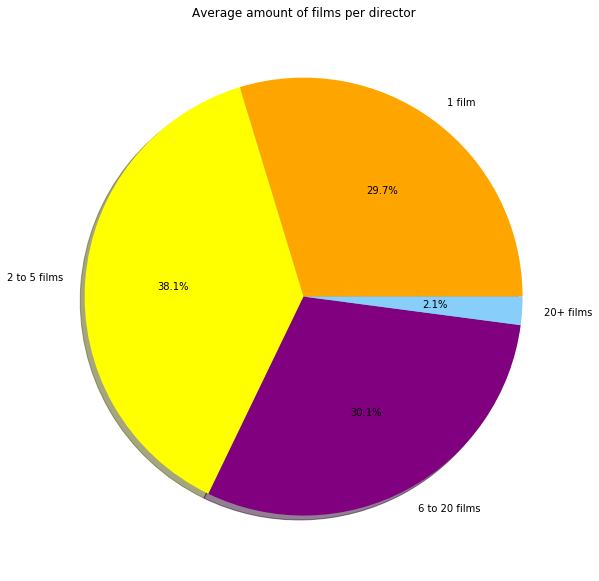

In [285]:
colors = ['orange', 'yellow', 'purple', 'lightskyblue', 'coral']
fig = plt.figure(figsize=(8,8))
plt.pie(values, labels=groups, colors=colors, autopct='%1.1f%%', shadow=True);
plt.tight_layout()
plt.title('Average amount of films per director')
plt.show()

### <font color=red>Answer to question #8</font>

The vast majority of directors have 2 to 5 films, followed by (surprisingly) and equal amount that have, on one side, 1 film, and on the other side, 6 to 20 films.

Finally, there 2% of our sample size are directors with over 20 films in their career. **Impressive**.

## <font color = green>9. How do votes, budgets and revenues behave through a single-variable exploration?<font>

#### First with votes (vote_average)

In [286]:
df_tmdb.vote_average.describe()

count    10800.000000
mean         5.970880
std          0.933006
min          1.500000
25%          5.400000
50%          6.000000
75%          6.600000
max          9.200000
Name: vote_average, dtype: float64

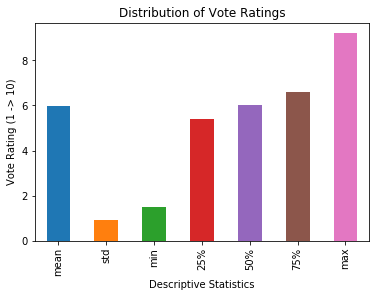

In [287]:
ax = df_tmdb.vote_average.describe().drop(['count']).plot(kind='bar');
set_title_and_axes_labels(ax, 'Distribution of Vote Ratings', 'Descriptive Statistics', 'Vote Rating (1 -> 10)')

From this quick chart, I can see that not only the average rating left by users is 6, however this is not because of a distribution between lows and highs. On the contrary, the 25%, 50% and 75% percentile are all near this number, so I dare say that the low rated and high rated films are the outliers in the dataframe.

#### Now let's move on to budgets and revenues

In [288]:
adj_budget_revenue_df = df_tmdb[['budget_adj', 'revenue_adj']].apply(lambda x: x/1000000)

In [289]:
#dropping nulls
adj_budget_revenue_df.isnull().sum()

budget_adj     0
revenue_adj    0
dtype: int64

In [290]:
adj_budget_revenue_df = adj_budget_revenue_df.query('budget_adj != 0').query('revenue_adj != 0')
adj_budget_revenue_df

,budget_adj,revenue_adj
0,137.999939,1392.445893
1,137.999939,348.161292
2,101.199955,271.619025
3,183.999919,1902.723130
4,174.799923,1385.748801
5,124.199945,490.314247
6,142.599937,405.355076
7,99.359956,547.749654
8,68.079970,1064.192017
9,160.999929,785.411575


In [291]:
adj_budget_revenue_df.budget_adj.describe()

count    3.853000e+03
mean     4.425038e+01
std      4.481043e+01
min      9.693980e-07
25%      1.309053e+01
50%      3.001664e+01
75%      6.061307e+01
max      4.250000e+02
Name: budget_adj, dtype: float64

#### This doesn't seem easy to understand by numbers, let's show it graphically

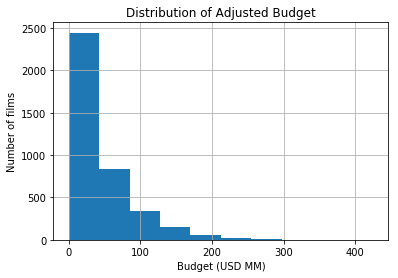

In [292]:
ax = adj_budget_revenue_df.budget_adj.hist();
set_title_and_axes_labels(ax, 'Distribution of Adjusted Budget', 'Budget (USD MM)', 'Number of films')

In [293]:
adj_budget_revenue_df.budget_adj.mean()

44.250376299499592

As we can see, the vast majority of films are made with under USD 100MM (With the average being USD 44MM), and this chart shows that it is extremely skewed to the right when compared to big budget films

#### Now for revenue

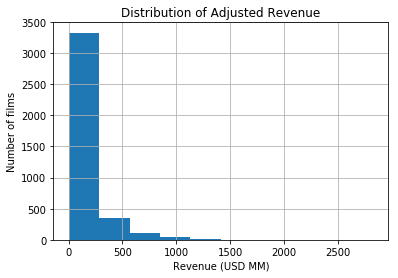

In [294]:
ax = adj_budget_revenue_df.revenue_adj.hist();
set_title_and_axes_labels(ax, 'Distribution of Adjusted Revenue', 'Revenue (USD MM)', 'Number of films')

In [295]:
adj_budget_revenue_df.revenue_adj.mean()

137.09737237865295

Similar to budget, the revenue of most films is skewed to the right, with the vast majority returning under 500M, with the mean showing "only"  137MM

#### Note on this question

We can see, fortunately, that the majority of films return, on average 3x their budget

## <a id='conclusions'></a>
## Conclusions


_Original Conclusions_
Most of the answers could have been common knowledge, however it is different "thinking" it is the truth vs validating it with data. Most of the answers were expected, however I was surprised by the budget of films for the past 55 years, and for the last question about the average amount of movies a director has.

The answers to each question was listed at the end of the exploratory data analysis for each of the questions.

#### _Expanded Conclusions_
1. Regarding cleaning data:

Few columns had missing information, therefore the cleaning process was fairly straightforward. The most diffcult task for me was the "genre" column, since I wanted to use it for so many things. However, the format (separated by pipe) made it difficult to do the analysis I needed (If you review above, all the analysis done by genre is using custom dataframes created by me, and not the original dataframe)

When I was looking at at the relationship between runtime and rating, I immediately saw that there were some odd values there (outliers) and proceeded to remove them, and then redid the analysis and obtained accurate results. I learned to always double check these "outliers"

Moreover, the sample size is very important. If I had simply used the dataframe as it came, the most popular movies would be very different (because they have very few votes, from big fans of the film, therefore they showed almost perfect scores, whereas the other films had hundreds of ratings, which would result in a much better representation of the actual popular films)

2. Regarding statistical sampling:

I believe that these results speak exclusively to Hollywood, and shouldn't be extrapolated to other countries.

3. Regarding correlations:

Fantasy, Animation and Adventure films were shown to be the ones with highest budget overall, however this doesn't need to be because of the genre itself. It could be because perhaps the studios behind them invest heavily in their films, and the scripts that mostly pass are from these genres, making them, by consequence, the most expensive films to produce.

4. Regarding limitations:

The data is based on Hollywood films, therefore should only be considered for the US market. We also don't have the information of revenue separated by foreign and domestic theaters, therefore we could argue that some films/genres could be more famous abroad than in the U.S., and even take into consideration currency devaluation of those countries against the performance of the films in the box office to have a better assessment.


## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [296]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0